# 7. Alfven operator

In [1]:
from numpy import linspace, meshgrid, pi, zeros, asarray
from scipy.linalg import eig

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Math

from sympy.core.containers import Tuple
from sympy import symbols
from sympy import Symbol
from sympy import Lambda
from sympy import IndexedBase

from gelato.glt import glt_symbol
from gelato.glt import glt_lambdify
from gelato.glt import glt_approximate_eigenvalues
from gelato.printing.latex import glt_latex
from gelato.calculus   import (Dot, Cross, Grad, Curl, Rot, Div)
from gelato.calculus   import Constant
from gelato.fem.assembly import assemble_matrix
from gelato.fem.utils    import compile_kernel
from gelato.fem.utils    import compile_symbol

from spl.fem.splines import SplineSpace
from spl.fem.tensor  import TensorFemSpace
from spl.fem.vector  import VectorFemSpace

In [2]:
x,y,z = symbols('x y z')

u = IndexedBase('u')
v = IndexedBase('v')

bx = Constant('bx')
by = Constant('by')
bz = Constant('bz')
b = Tuple(bx, by, bz)

c0,c1,c2 = symbols('c0 c1 c2')

a = Lambda((x,y,z,v,u), (  c0 * Dot(u, v)
                         + c1 * Div(u) * Div(v)
                         + c2 * Dot(Curl(Cross(b,u)), Curl(Cross(b,v)))))


In [4]:
# ...  create a finite element space
p1  = 2 ; p2  = 2 ; p3  = 2
ne1 = 8 ; ne2 = 8 ; ne3 = 8

grid_1 = linspace(0., 1., ne1+1)
grid_2 = linspace(0., 1., ne2+1)
grid_3 = linspace(0., 1., ne3+1)

V1 = SplineSpace(p1, grid=grid_1)
V2 = SplineSpace(p2, grid=grid_2)
V3 = SplineSpace(p3, grid=grid_3)

W = TensorFemSpace(V1, V2, V3)
# ...

V = VectorFemSpace(W, W, W)

In [5]:
from IPython.display import Math
from gelato.printing.latex import glt_latex
from sympy import latex

symbol = glt_symbol(a, space=V, evaluate=False)

Math(latex(symbol))
#Math(glt_latex(symbol))

<IPython.core.display.Math object>

In [6]:
d_types = {'c0': 'double', 'c1': 'double', 'c2': 'double', 
           'bx': 'double', 'by': 'double', 'bz': 'double'}

In [7]:
kernel = compile_kernel('kernel_alfven', a, V,
                        d_args=d_types,
                        backend='fortran')

In [8]:
symbol_f90 = compile_symbol('symbol_alfven', a, V, 
                            d_args=d_types,
                            backend='fortran')

In [9]:
d_args = {'c0': 1.e-12, 'c1': 1.e-4, 'c2': 1.e-2, 
          'bx': 0., 'by': 0., 'bz': 1.}

In [10]:
M = assemble_matrix(V, kernel, args=d_args)

In [11]:
from utils import coo_from_blocks

n_block_rows = 3 ; n_block_cols = 3
matrices = []
for ir in range(0, n_block_rows):
    line = []
    for ic in range(0, n_block_cols):
        coo = M[ir][ic].tocoo() 
        coo.eliminate_zeros()
        line.append(coo)
    matrices.append(line)
_M = M    
M = coo_from_blocks(matrices, 
                    n_block_rows=n_block_rows, 
                    n_block_cols=n_block_cols)

In [12]:
# import eigenvalue solver
from scipy.linalg import eig

M = M.todense()
w, v = eig(M)
wr = w.real
wr.sort()

In [13]:
# ... example of symbol evaluation
n1 = V1.nbasis
n2 = V2.nbasis
n3 = V3.nbasis
t1 = linspace(-pi,pi, n1)
t2 = linspace(-pi,pi, n2)
t3 = linspace(-pi,pi, n3)
x1 = linspace(0.,1., n1)
x2 = linspace(0.,1., n2)
x3 = linspace(0.,1., n3)
e = zeros((3, 3, n1, n2, n3), order='F')
symbol_f90(x1,x2,x3,t1,t2,t3, e, 
           d_args['bx'], d_args['by'], d_args['bz'], 
           d_args['c0'], d_args['c1'], d_args['c2'])
# ...

In [14]:
W = []
for i1 in range(0, n1):
    for i2 in range(0, n2):
        for i3 in range(0, n3):
            mat = e[:,:,i1,i2,i3]
            w,v = eig(mat)
            W += list(w.real)
t = asarray(W)
t.sort()

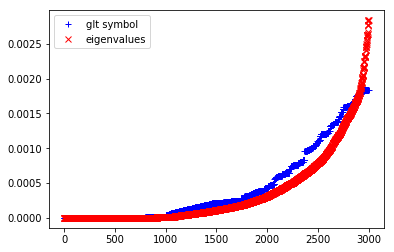

In [15]:
plt.plot(t, "+b", label="glt symbol")
plt.plot(wr, "xr", label="eigenvalues")
plt.legend(loc=2);

In [16]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()